# Machine Learning
A lot of the code is copied from another project (see Note 1). But, I have taken the time to understand how each section works and implementing what I've learnt from books I've read, to this project.



- Note1: using (https://github.com/shsarv/Machine-Learning-Projects/blob/main/Diabetes%20Prediction%20%5BEND%202%20END%5D/Diabetes%20Classification.ipynb) to help make a my first proper machine learning program
- Note2: One piece of code I changed to comply with pandas 3.0 (not using inplace = True for filling in NaN values with the mean/median)
- Note3: I know it would've been better to change the column titles to something shorter but I just want to make my first ML program. I'll worry about that stuff with other projects

In [227]:
# Libraries

# csv, sql related
import csv, datetime
import sqlite3, sqlalchemy
from contextlib import closing

# pandas and numpy
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

# graphing
import seaborn as sb
import matplotlib.pyplot as plt

# machine learning-sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB as GNB

%matplotlib inline

In [228]:
# Opening a csv file and creating a DataFrame object from it
def file_to_DF(file_name, r_or_w, var_name):
    with open(file_name, r_or_w) as var_name:
        fileDF = pd.read_csv(var_name)
        return fileDF

#### Data Cleaning

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N  

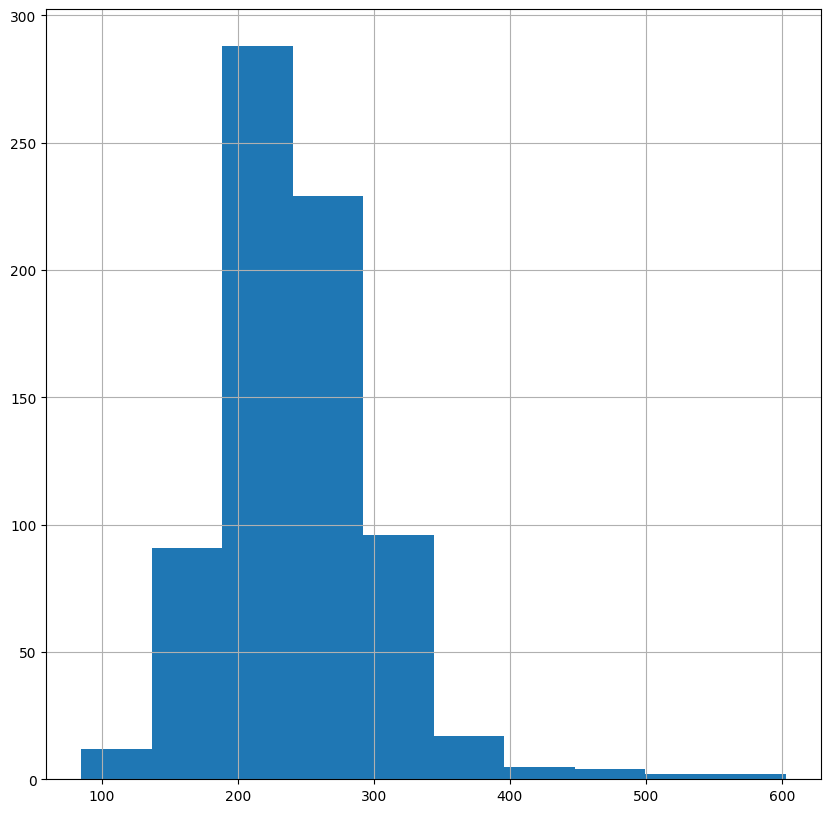

In [229]:
heartFailure = file_to_DF("heart.csv", "r", "heartDF")
print(heartFailure)

# stats
print(heartFailure.describe().T)  # .T ensures any stats cal are done only on numeric columns
is_zero = heartFailure.isin([0]).sum(axis=0)  # finding what cells have the value of 0; if need be, they will be filled with the median or mean
print(is_zero)

# making a copy
hf_copy = heartFailure.copy(deep = True)  # any changes made to the original DF, will affect the copy but not the other way round
# (optional/if need be) removing zero values from columns
hf_copy['Cholesterol']= hf_copy['Cholesterol'].replace(0, np.nan)  # replaces 0 with NaN
chol_hist = hf_copy['Cholesterol'].hist(figsize=(10,10))  # position of histogram determines if mean or median is used for filling
                                                            #  use the copy where 0 val has been replaced with NaN -> this is to see the true distribution
hf_copy['Cholesterol'] = hf_copy['Cholesterol'].fillna(hf_copy['Cholesterol'].median())
print(hf_copy.isnull().sum())  # checking there are no null values


#### Encoding qualitative variables
Columns to encode:
- ChestPainType(cpt), RestingECG(recg), ExerciseAngina(ea), ST_Slope(sts)
- Note: for this and any subsequent projects that aren't very large, the columns will be renamed for ease of use

In [230]:
ohe = OneHotEncoder()

# applies one hot encoding to column(s) but returns an array
cpt = ohe.fit_transform(hf_copy[['ChestPainType']]).toarray()  
recg = ohe.fit_transform(hf_copy[['RestingECG']]).toarray()
ea = ohe.fit_transform(hf_copy[['ExerciseAngina']]).toarray()

# converting the arrays into dataframes 
cpt_df = pd.DataFrame(cpt, index=hf_copy.index, columns=['ASY', 'ATA', 'NAP', 'TA'])  # converting the array to a DataFrame
recg_df = pd.DataFrame(recg, index=hf_copy.index, columns=['LVH', 'Normal', 'ST'])
ea_df = pd.DataFrame(ea, index=hf_copy.index, columns=['N', 'Y'])

# merging them into the main dataset (HeartFailure)
hf_concat = pd.concat([hf_copy, cpt_df, recg_df, ea_df], axis=1)
print(hf_concat)
ohe.categories_

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140        289.0          0     Normal   
1     49   F           NAP        160        180.0          0     Normal   
2     37   M           ATA        130        283.0          0         ST   
3     48   F           ASY        138        214.0          0     Normal   
4     54   M           NAP        150        195.0          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110        264.0          0     Normal   
914   68   M           ASY        144        193.0          1     Normal   
915   57   M           ASY        130        131.0          0     Normal   
916   57   F           ATA        130        236.0          0        LVH   
917   38   M           NAP        138        175.0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak  ... HeartDisease  ASY  ATA  NAP   TA  LVH  \
0     

[array(['N', 'Y'], dtype=object)]

#### Making the model pt1 - Testing which model to use

In [231]:
hf_main_copy = hf_concat
# creating the training and testing set
col_drop = ['Sex', 'ChestPainType', 'RestingECG',
            'ExerciseAngina', 'ST_Slope', 'HeartDisease']

X = hf_main_copy.drop(columns=col_drop)
y = hf_main_copy['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))  # variable no of rows, same no of columns

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# using GridSearchCV to find the best model; I have barely an idea in any of the parameters in the models
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs'),  # lbfgs: optimisation algorithm to allow for another algorithm (BFGS algorithm) to run on limited memory
            'parameters':{
                'C': [1, 5, 10]
            }
        },
        'LDA': {
            'model': LDA(),  
            'parameters':{
                'solver': ['svd', 'lsqr']  # type of decomposition to use -> single value decomposition, least squares, eigen decomposition
            }
        },
        'QDA': {
            'model': QDA(),
             'parameters':{
                'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]  # each class has its own covariance; need to choose best value for covariance
            }
        },
        'GaussianNB':{
            'model': GNB(),
             'parameters':{
                'var_smoothing': np.logspace(0, -9, num=100)  # var_smoothing: making sure all the variances are similar by adding the largest variance of all features to every other variance 
            }
        }
    }
    scores = []
    cv_shuffle =  ShuffleSplit(n_splits=5, test_size=0.20,  random_state=42)  # using k-fold CV -> 5 splits, each with a test size of 20% 

    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'parameters': gs.best_params_,
            'score': gs.best_score_
        })
    return pd.DataFrame(scores, columns=['model', 'best_params', 'score'])

which_model = find_best_model(X_train, y_train)
print(which_model)

# avg accuracy for Gaussian Naive Bayes
scores = cross_val_score(GNB(),  X_train, y_train, cv=5) 
acc = round(sum(scores)*100/len(scores), 3)
print(f"Avg accuracy: {acc}%")

X_train size: (734, 15), X_test size: (184, 15)
                 model  best_params     score
0  logistic_regression          NaN  0.814966
1                  LDA          NaN  0.813605
2                  QDA          NaN  0.812245
3           GaussianNB          NaN  0.816327
Avg accuracy: 81.196%


#### Making the model pt2 - creation

In [232]:
classifier = GNB()  # GaussianNaiveBayes
classifier.fit(X_train, y_train)  # fitting training data to the model 

GaussianNB()

#### Model evaluation
- Correlation matrix
- Observing the accuracy rate by comparing when using the testing data vs the training data

[[67 10]
 [26 81]]
Accuracy on test set: 80.43%
Test set accuracy: 80.43
Train set accuracy:  82.02000000000001


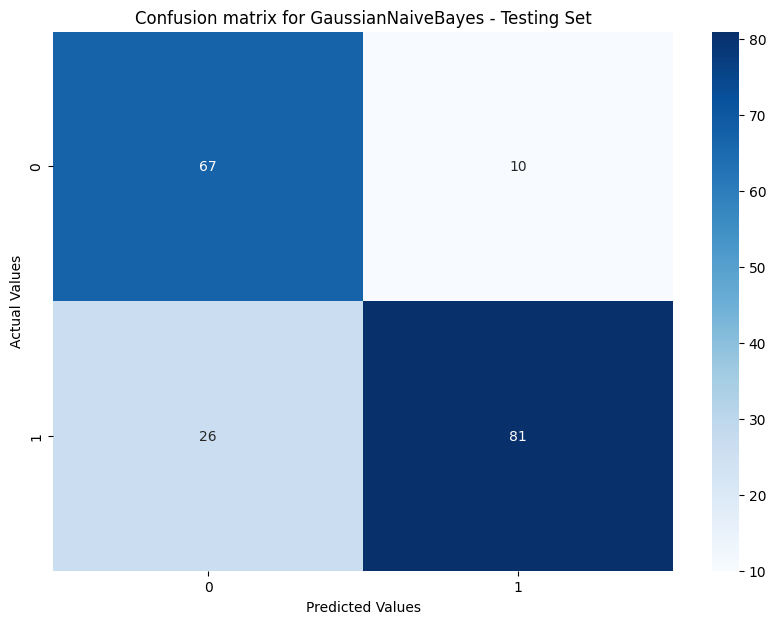

In [233]:
# Creating a confusion matrix  - Test data
y_pred = classifier.predict(X_test)  # creating predictions from the testing set, X_test
conf_mat = confusion_matrix(y_test, y_pred)  # confusion matrix: to see how many predicted values (y_pred) 
                                             # match the true vales (y_test)
print(conf_mat)

# confusion matrix graphic
plt.figure(figsize=(10,7))
cmf_heat = sb.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")  # 1st param = confusion matrix data, annot=Displaying the values in the matrix, cmap=colour of the matrix, fmt=string formatting
plt.title('Confusion matrix for GaussianNaiveBayes - Testing Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');

# calculating the accuracy rate of the model based on the test set
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))
'''
BREAK
'''
# comparing accuracy rate for training data
y_train_pred = classifier.predict(X_train)
score_train = round(accuracy_score(y_train, y_train_pred),4)*100
print('Test set accuracy: '+str(score)+'\n'+'Train set accuracy:  '+str(score_train))

#### Creating a function to predict heart disease
Note: I could use switch statements but, it'd get a bit too complicated so I'll leave as is

Overall output: not working. Keeps outputting the value 1 even if the patient is healthy

In [234]:
print(X.columns)
def heart_detect(Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, ASY, ATA, NAP, TA, LVH, Normal, ST, N, Y):
    x = [[Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, ASY, ATA, NAP, TA, LVH, Normal, ST, N, Y]]
    x = sc.transform(x)
    return classifier.predict(x) 

predict = heart_detect(25, 50, 80, 70, 130, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0)[0]  # healthy person
predict = heart_detect(25, 170, 200, 170, 300, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1)[0]
if (predict >= 0.5) and (predict <=1) :
    print(predict)
    print("Likely chance of heart disease")
else:
    print("Unlikely chance of heart disease")

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'ASY', 'ATA', 'NAP', 'TA', 'LVH', 'Normal', 'ST', 'N', 'Y'],
      dtype='object')
1
Likely chance of heart disease


C:\Users\TheWorkHorseUPGRADED\PycharmProjects\DataAnalysisPortfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\TheWorkHorseUPGRADED\PycharmProjects\DataAnalysisPortfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Statistical Analysis